In [1]:
!nvidia-smi

Tue Aug 19 19:23:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
tf.random.set_seed(4)

In [4]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2025-08-19 19:23:51--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/yzldvhixewlfrtdatr3m9/archive.zip?rlkey=azh4epb0r6uqwe1vh74jctsnh [following]
--2025-08-19 19:23:52--  https://www.dropbox.com/scl/fi/yzldvhixewlfrtdatr3m9/archive.zip?rlkey=azh4epb0r6uqwe1vh74jctsnh
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea66ad09eccfeefcc4809d4758.dl.dropboxusercontent.com/cd/0/inline/CvsQj9DrHgCoj_cm8O7TD8ioOO5u53NS7ubGVoJB332j3CXatNLAE6GHI6rRcyTamlscw3U5qw82edzFuFuFq6c76pw33kyHR12buKXKQ-8SjogcVDmDIVJQcIqdJFWGXtMmTdL93eIS2XUAMzOk8tAG/file# [following]
--2025-08-19 19:23:52--  https://ucea66ad09eccfeefcc4809d4758.dl.dropboxusercontent.com/cd/0/inline/C

In [5]:
!unzip -q "archive.zip"

In [6]:
#PathLib Path objects
train_path=Path("chest_xray/train")
val_path=Path("chest_xray/val")
test_path=Path("chest_xray/test")

In [7]:
train_image_paths = train_path.glob("*/*")
val_image_paths = val_path.glob("*/*")
test_image_paths = test_path.glob("*/*")

print(train_image_paths)

<generator object Path.glob at 0x7ab6123ca020>


In [8]:
train_image_paths=list(train_image_paths)
val_image_paths=list(val_image_paths)
test_image_paths=list(test_image_paths)

print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0469-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1126-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0531-0001-0001.jpeg')]


In [9]:
print(train_image_paths[-3:])

[PosixPath('chest_xray/train/PNEUMONIA/person1366_virus_2349.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person704_virus_1301.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person281_bacteria_1329.jpeg')]


In [10]:
train_image_paths=list(map(lambda x: str(x),train_image_paths))
val_image_paths=list(map(lambda x: str(x),val_image_paths))
test_image_paths=list(map(lambda x: str(x),test_image_paths))
print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0469-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1126-0001.jpeg', 'chest_xray/train/NORMAL/IM-0531-0001-0001.jpeg']


In [11]:
train_dataset_len=len(train_image_paths)
val_dataset_len=len(val_image_paths)
test_dataset_len=len(test_image_paths)

print(train_dataset_len,val_dataset_len,test_dataset_len)

5216 16 624


In [12]:
labels={'NORMAL':0,'PNEUMONIA':1}
inv_labels={0:'NORMAL',1:'PNEUMONIA'}
def get_label(path:str)->int:
  return labels[path.split("/")[-2]]

train_labels=list(map(lambda x: get_label(x),train_image_paths))
val_labels=list(map(lambda x: get_label(x),val_image_paths))
test_labels=list(map(lambda x: get_label(x),test_image_paths))
print(train_labels[:3])

[0, 0, 0]


In [13]:
#a transformation function
batch_size=32
def load_and_transform(image,label,train=True):
  image=tf.io.read_file(image)
  image=tf.io.decode_jpeg(image,channels=3)
  image=tf.image.resize(image,[224,224],method="nearest")
  if train:
    image=tf.image.random_flip_left_right(image)
  return image,label

In [23]:
#create a tensorflow object
def get_dataset(paths,labels,train=True):
  image_paths=tf.convert_to_tensor(paths)
  labels=tf.convert_to_tensor(labels)

  image_dataset=tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset=tf.data.Dataset.from_tensor_slices(labels)

  dataset=tf.data.Dataset.zip((image_dataset,label_dataset)).shuffle(1000)

  dataset=dataset.map(lambda image,label:load_and_transform(image,label,train))
  #dataset=dataset.repeat()##this is indefinite, so steps_per_epoch needs to be defined in fit()
  dataset=dataset.shuffle(2048)
  dataset=dataset.batch(batch_size)

  return dataset

In [24]:
#create a train dataset object and verify it
%time train_dataset=get_dataset(train_image_paths,train_labels)
image,label=next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 48.3 ms, sys: 30 µs, total: 48.3 ms
Wall time: 48.6 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


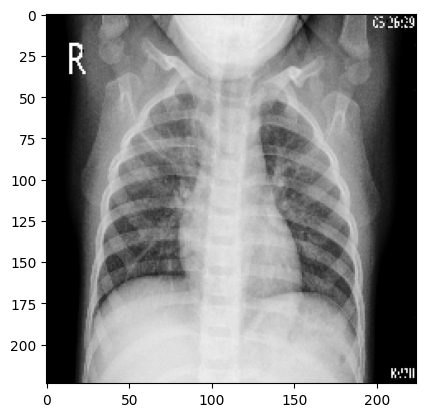

In [25]:
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [26]:
%time val_dataset = get_dataset(val_image_paths,val_labels,train=False)
image,label=next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 26.9 ms, sys: 0 ns, total: 26.9 ms
Wall time: 29.3 ms
(16, 224, 224, 3)
(16,)


In [53]:
from tensorflow.keras.applications import ResNet50V2
backbone=ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
)
model=tf.keras.Sequential([backbone,tf.keras.layers.GlobalAveragePooling2D(),
                           tf.keras.layers.Dense(256,activation='relu'),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,601 (91.89 MB)

 Trainable params: 24,044,161 (91.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [54]:
#compile model by providing the optimizer , loss and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.009,epsilon=1e-07),
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)


In [55]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.weights.h5",
                            verbose=1,save_best_only=True,
                            save_weights_only=True)
early_stop=tf.keras.callbacks.EarlyStopping(patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001,mode='auto')


In [56]:
#train
history=model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_len//batch_size,
    epochs=8,
    callbacks=[checkpoint,early_stop,reduce_lr],
    validation_data=val_dataset,
    validation_steps=val_dataset_len//batch_size
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8817 - loss: 0.2905 - precision: 0.8978 - recall: 0.8974
Epoch 1: val_loss improved from inf to 41.47828, saving model to best.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 304ms/step - accuracy: 0.8820 - loss: 0.2899 - precision: 0.8981 - recall: 0.8977 - val_accuracy: 0.6250 - val_loss: 41.4783 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9474 - loss: 0.1431 - precision: 0.9478 - recall: 0.9647
Epoch 2: val_loss improved from 41.47828 to 3.75629, saving model to best.weights.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 295ms/step - accuracy: 0.9475 - loss: 0.1428 - precision: 0.9479 - recall: 0.9648 - val_accuracy: 0.6875 - val_loss: 3.7563 - val_precision: 0.6154 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9457 - loss: 0.1678 - precision: 0.9446 - recall: 0.9685
Epoch 3:

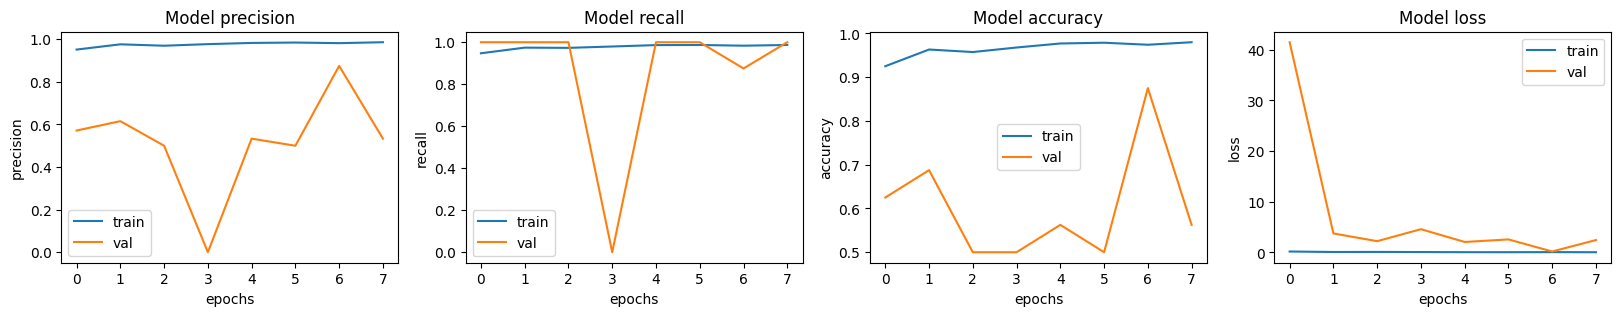

In [59]:
fig,ax = plt.subplots(1,4,figsize=(20,3))
ax=ax.ravel()
for i,met in enumerate(['precision','recall','accuracy','loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_'+met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_ylabel(met)
  ax[i].set_xlabel('epochs')
  ax[i].legend(['train','val'])



In [58]:
import joblib
from joblib import dump,load
#joblib.dump(model,'model.pkl')

In [60]:
#joblib.dump(model,'m2.pkl')

['m2.pkl']

In [61]:
#model.load_weights('best.weights.h5')
#model.save('model.h5')

In [77]:
loaded_model = tf.keras.models.load_model("model.h5")
loaded_model2 = joblib.load("m2.pkl")
loaded_model3 = joblib.load("model.pkl")

In [78]:
test_image_paths=tf.convert_to_tensor(test_image_paths)
test_labels-tf.convert_to_tensor(test_labels)
def decode_image(image,label):
  image=tf.io.read_file(image)
  image=tf.io.decode_jpeg(image,channels=3)
  image=tf.image.resize(image,[224,224],method='nearest')
  return image,label
#create an object
test_dataset=(tf.data.Dataset
              .from_tensor_slices((test_image_paths,test_labels))
              .map(decode_image)
              .batch(batch_size))

In [79]:
image,label=next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


NORMAL


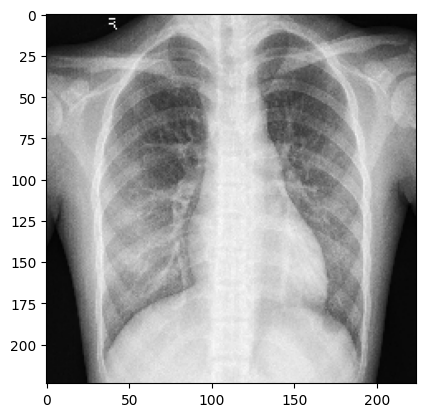

In [80]:
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [81]:
#m2.pkl
loss,acc,prec,rec=loaded_model2.evaluate(test_dataset)
print(" Testing Acc: ",acc)
print(" Testing Precision: ",prec)
print(" Testing Recall: ",rec)
print(" Testing Loss: ",loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.3238 - loss: 8.1912 - precision: 0.3048 - recall: 0.6667
 Testing Acc:  0.6410256624221802
 Testing Precision:  0.6351791620254517
 Testing Recall:  1.0
 Testing Loss:  4.2318501472473145


In [76]:
#model.pkl
loss,acc,prec,rec=loaded_model3.evaluate(test_dataset)
print(" Testing Acc: ",acc)
print(" Testing Precision: ",prec)
print(" Testing Recall: ",rec)
print(" Testing Loss: ",loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.4999 - loss: 2.5676 - precision: 0.3507 - recall: 0.6639
 Testing Acc:  0.7371794581413269
 Testing Precision:  0.7047101259231567
 Testing Recall:  0.9974358677864075
 Testing Loss:  1.385514259338379


In [68]:
#model.h5
loss,acc,prec,rec=loaded_model.evaluate(test_dataset)
print(" Testing Acc: ",acc)
print(" Testing Precision: ",prec)
print(" Testing Recall: ",rec)
print(" Testing Loss: ",loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 346ms/step - accuracy: 0.6654 - loss: 1.4385 - precision: 0.4044 - recall: 0.6475
 Testing Acc:  0.8060897588729858
 Testing Precision:  0.7761806845664978
 Testing Recall:  0.9692307710647583
 Testing Loss:  0.8438621163368225


steps:  
1) research the problem statement (X-ray Scanners by different companies are huge in pixel level, hence we need variety of machines)  
2) We cannot use most augmentations  
they might change the image itself  
hence we use ones that do not affect pixel values (horizontal rotations, random image cropping)  
We could try Blurring images in a minimal way, too  
3) we need to introduce more callbacks (LRScheduler, Reduce on Plateau, or custom)
try other models (Inception,EfficientNets, NasNets)
try different models